In [2]:
# Instala bibliotecas
!pip install transformers
!pip install datasets
!pip install torch
!pip install evaluate
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.3 MB/s eta 0:00:00


In [3]:
# Configura uso do MLFlow no Colab
import mlflow
import mlflow.pytorch

MLFLOW_TRACKING_URI = "file:/content/mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("project_amazon_reviews_bert")

!nohup mlflow ui --backend-store-uri /content/mlruns --host 0.0.0.0 --port 5001 > mlflow.log 2>&1 &

mlflow.end_run()  # fecha qualquer run
mlflow.start_run(run_name=None)
mlflow.end_run()

# limpa também ambiente da UI
mlflow.autolog(disable=True)

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/06 17:58:57 INFO mlflow.tracking.fluent: Experiment with name 'project_amazon_reviews_bert' does not exist. Creating a new experiment.


In [4]:
# Configura variáveis globais do modelo
model_id = "distilbert-base-uncased" # eu irei usar este, pois é rápido e leve, e irei usar o Colab, o que limita um pouco as coisas...
max_length= 128
num_labels = 2
batch_size = 16
results_path = "./results"
pretrained_path = "./sentiment-analysis-bert"

In [5]:
# Importa bibliotecas

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
import evaluate
from torch.utils.data import DataLoader, SequentialSampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import wandb

wandb.init(mode="disabled")  # Desabilita o Wandb

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [6]:
# Carrega o dataset que tem train e test
# Adicionei os arquivos da pasta data/processed no Colab
import pandas as pd

data_train = pd.read_parquet("amazon_reviews_train_sample.parquet")
data_test = pd.read_parquet("amazon_reviews_test_sample.parquet")

In [7]:
# Converte para DataFrame
from datasets import Dataset

ds_train = Dataset.from_pandas(data_train)
ds_test = Dataset.from_pandas(data_test)

# Divide o treino em 80% e 20%, sendo os 80 para treino e os 20 para validação
ds_train_split = ds_train.train_test_split(test_size=0.2)

# Monta o dataset com todas as partes train, test e val
dataset = DatasetDict({
    "train": ds_train_split["train"],
    "test": ds_test,
    "val": ds_train_split["test"],
})

# Separa as partes do dataset
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['val']

In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['rating', 'review_title', 'review_text', 'text_length', 'labels', '__index_level_0__'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['rating', 'review_title', 'review_text', 'labels'],
        num_rows: 400000
    })
    val: Dataset({
        features: ['rating', 'review_title', 'review_text', 'text_length', 'labels', '__index_level_0__'],
        num_rows: 6000
    })
})


In [9]:
def show_info_dataset(dataset, title):
    # Converter o dataset para um DataFrame do pandas
    df = dataset.to_pandas()

    # Contar as ocorrências na coluna 'label'
    label_counts = df['labels'].value_counts()

    # Mapeamento dos labels para nomes
    label_names = {0: 'Negativo', 1: 'Positivo'}

    # Obter os nomes das labels
    labels = [label_names[label] for label in label_counts.index]

    # Definir as cores para cada label
    colors = ['blue', 'red']

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, label_counts, color=colors)

    # Adicionar os totais em cima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

    # Configurar o título e os rótulos dos eixos
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Total')
    plt.show()

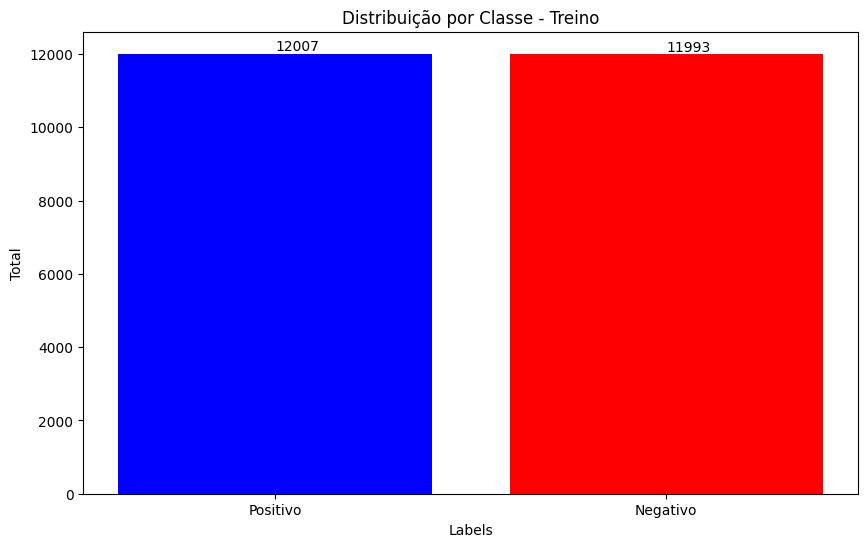

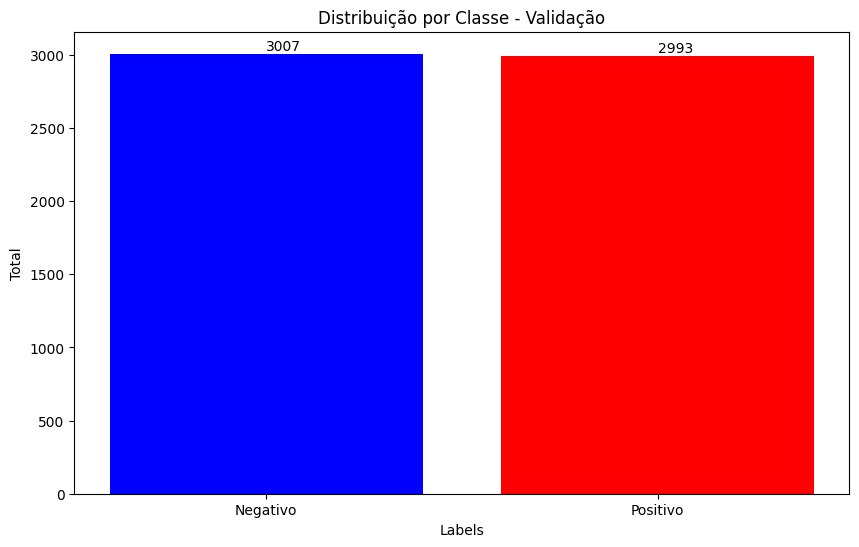

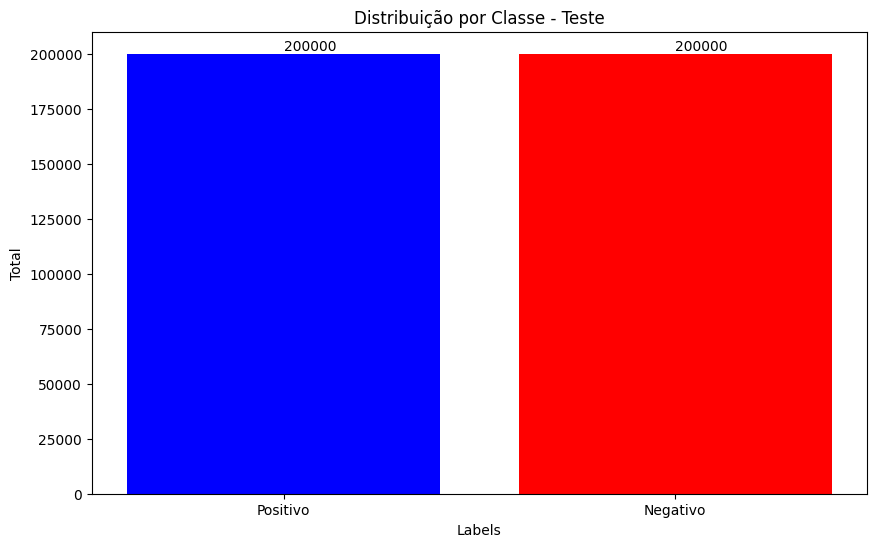

In [10]:
show_info_dataset(train_dataset, 'Distribuição por Classe - Treino')
show_info_dataset(val_dataset, 'Distribuição por Classe - Validação')
show_info_dataset(test_dataset, 'Distribuição por Classe - Teste')

In [11]:
# Tokenização
from transformers import AutoTokenizer  # Or BertTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding='max_length', truncation=True, max_length=max_length)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [12]:
# Formatando datasets para que o trainer da Hugging Face possa processá-los corretamente
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [17]:
# Configuração do modelo Bert
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Função de avaliação
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Transforma os logits (saída do modelo) em previsões de classe, atribuindo a cada exemplo a classe com a
    # maior probabilidade, ou seja, a que tem o maior valor de logit.
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    return metric.compute(predictions=predictions, references=torch.tensor(labels))

In [19]:
# Configuração dos argumentos do treinamento
training_args = TrainingArguments(
    output_dir=results_path,                  # Diretório de saída para os resultados
    eval_strategy="epoch",                    # Estratégia de avaliação (avaliar a cada época)
    learning_rate=3e-5,                       # Taxa de aprendizado
    per_device_train_batch_size=batch_size,   # Tamanho do batch de treino
    per_device_eval_batch_size=batch_size,    # Tamanho do batch de avaliação
    num_train_epochs=3,                       # Número de épocas de treinamento
    weight_decay=0.01,                        # Decaimento de peso
)

In [20]:
## Treinamento do modelo
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="bert_run"):
    mlflow.log_param("model_id", model_id)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", 3)
    mlflow.log_param("max_length", max_length)

    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      compute_metrics=compute_metrics
    )

    trainer.train()

    # avaliação do modelo
    results = trainer.evaluate(eval_dataset=test_dataset)
    print(results)
    print(f"Acurácia no conjunto de teste: {results['eval_accuracy']}")
    mlflow.log_metric("accuracy", results["eval_accuracy"])



    # salvar modelo e tokenizer localmente no formato transformers
    import os

    model_save_dir = os.path.join("distilbert", "distilbert-base-uncased")
    trainer.save_model(model_save_dir)
    tokenizer.save_pretrained(model_save_dir)

    # logar artefatos no mlflow
    mlflow.pytorch.log_model(pytorch_model=model, artifact_path="model_pytorch")
    # log tokenizer files como artifacts
    mlflow.log_artifact(model_save_dir)

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.
2025/12/06 18:05:45 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id b8a59aaddf9243c88c8f8759294914f8: Failed to log run data: Exception: Changing param values is not allowed. Param with key='max_length' was already logged with value='128' for run ID='b8a59aaddf9243c88c8f8759294914f8'. Attempted logging new value '20'.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.234900,0.234194,0.915667
2,0.145500,0.251785,0.921333
3,0.064300,0.341616,0.921000


{'eval_loss': 0.3424609899520874, 'eval_accuracy': 0.92264, 'eval_runtime': 1492.4476, 'eval_samples_per_second': 268.016, 'eval_steps_per_second': 16.751, 'epoch': 3.0}
Acurácia no conjunto de teste: 0.92264


2025/12/06 18:47:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 18:47:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/06 18:47:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.24.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [21]:
# Avaliação do Modelo - Predict
raw_pred, _, _ = trainer.predict(test_dataset=test_dataset)

In [22]:
def show_info(y_true, y_pred, title='Confusion matrix', cmap='Blues'):
    target_names = ['Negativo', 'Positivo']
    print(classification_report(y_true, y_pred, target_names=target_names))

    plt.figure(figsize=(16, 10))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap=plt.cm.Blues,values_format='g')
    plt.show()

              precision    recall  f1-score   support

    Negativo       0.93      0.91      0.92    200000
    Positivo       0.92      0.93      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



<Figure size 1600x1000 with 0 Axes>

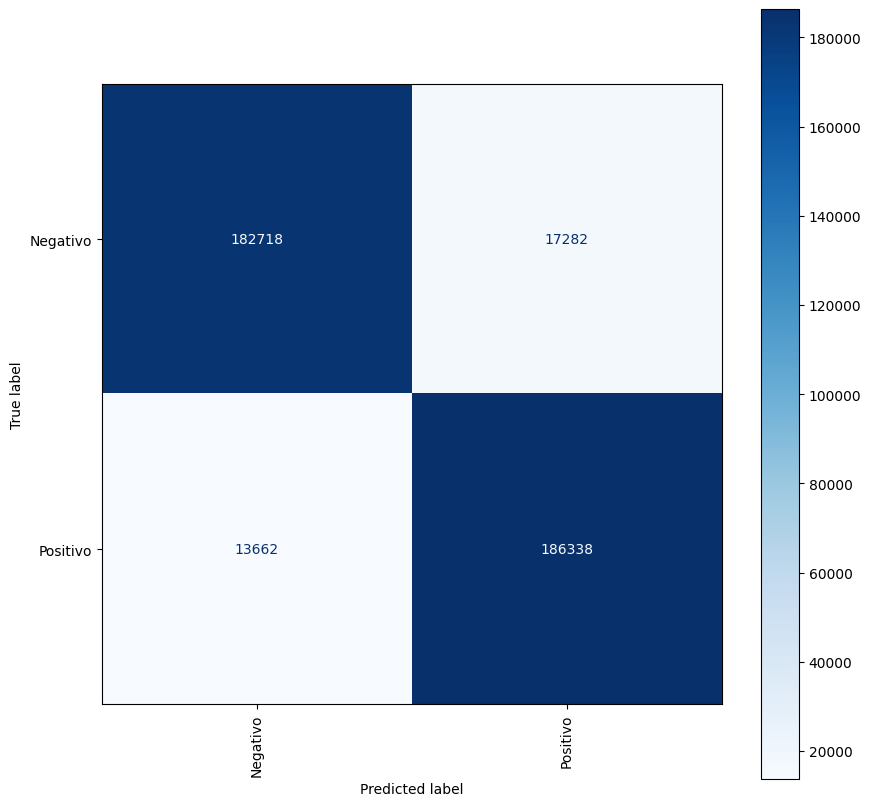

In [23]:
# Pré-processar previsões brutas
y_pred = np.argmax(raw_pred, axis=1)
y_true = test_dataset["labels"]

show_info(y_true, y_pred)

In [24]:
# Salvar modelo
model.save_pretrained(pretrained_path)
tokenizer.save_pretrained(pretrained_path)

('./sentiment-analysis-bert/tokenizer_config.json',
 './sentiment-analysis-bert/special_tokens_map.json',
 './sentiment-analysis-bert/vocab.txt',
 './sentiment-analysis-bert/added_tokens.json',
 './sentiment-analysis-bert/tokenizer.json')

In [25]:
# Predição de novos exemplos
def predict_sentiment(text):
    # Certificar que o modelo e os inputs estão no mesmo dispositivo (CPU ou GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokeniza o texto, aplica padding e truncamento, converte para tensor PyTorch e move os dados para o dispositivo especificado.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        # Executa o modelo com as entradas fornecidas, passando os tensores de input como argumentos para gerar as previsões ou saídas do modelo.
        outputs = model(**inputs)

    # Aplica a função softmax as saídas do modelo para converter os valores em probabilidades, normalizadas ao longo da última dimensão.
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Retorna a maior probabilidade
    return probs.argmax().item()

example_text = "Best product ever!"
predicted_label = predict_sentiment(example_text)
sentiment = ['Negativo', 'Positivo']
print(f"Sentimento previsto: {sentiment[predicted_label]}")

Sentimento previsto: Positivo


In [26]:
example_text = "It stopped working after 3 months"
predicted_label = predict_sentiment(example_text)
sentiment = ['Negativo', 'Positivo']
print(f"Sentimento previsto: {sentiment[predicted_label]}")

Sentimento previsto: Negativo


In [27]:
example_text = "It is ok for the price i payed"
predicted_label = predict_sentiment(example_text)
sentiment = ['Negativo', 'Positivo']
print(f"Sentimento previsto: {sentiment[predicted_label]}")

Sentimento previsto: Negativo


In [28]:
example_text = "It is not that pretty, but it works!!"
predicted_label = predict_sentiment(example_text)
sentiment = ['Negativo', 'Positivo']
print(f"Sentimento previsto: {sentiment[predicted_label]}")

Sentimento previsto: Positivo


In [29]:
# Salvar na máquina local
!zip -r mlruns.zip mlruns
from google.colab import files
files.download("mlruns.zip")

  adding: mlruns/ (stored 0%)
  adding: mlruns/models/ (stored 0%)
  adding: mlruns/499877906188223767/ (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/ (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/ (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/auto_find_batch_size (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/tpu_num_cores (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/save_strategy (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/ddp_bucket_cap_mb (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/dtype (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/finetuning_task (stored 0%)
  adding: mlruns/499877906188223767/b8a59aaddf9243c88c8f8759294914f8/params/ray_scope (stored 0%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>